In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

In [3]:
# Load the CSV files
movies = pd.read_csv(r"movies.csv")
ratings = pd.read_csv(r"ratings.csv")

# 1. Data Visualization

In [4]:
# Create a map of movielD -> title
totitle = {m: n for m, n, _ in movies.values.tolist()}

# Create a map of movielD -> genre
togenre = {m: g for m, _, g in movies.values.tolist()}

## Most viewed movies visualization

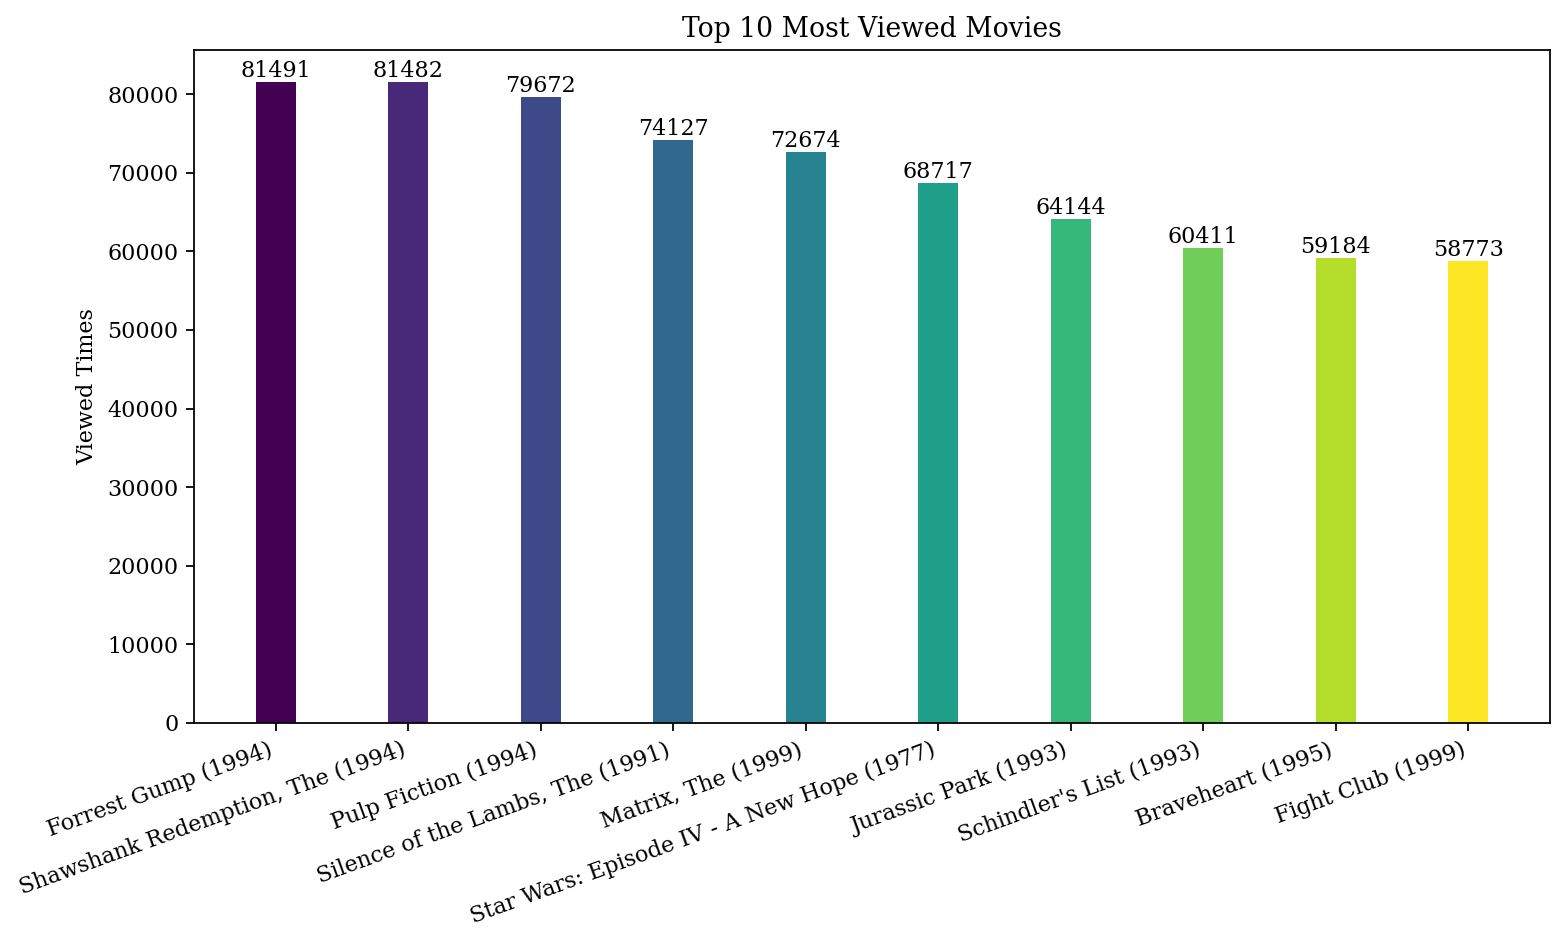

In [5]:
# Count the number of views for each movie
movies_num = Counter(ratings["movieId"].tolist())

# Sort the movies by the number of views
movies_sort = sorted(movies_num.items(), key=lambda kv: kv[1], reverse=True)

# Extract the top 10 movies and their view counts
top_movies = movies_sort[:10]
names = [totitle[m] for m, _ in top_movies]
num_views = np.array([view_count for _, view_count in top_movies])

# Plot settings
config = {
    "font.family": "serif", 
    "font.size": 10,
    "mathtext.fontset": 'stix',
}
rcParams.update(config)

plt.figure(dpi=160, figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 10))

# Create bar plot
bar_width = 0.3
bars = plt.bar(np.arange(len(names)), num_views, bar_width, color=colors)

# Adding text on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=20)
plt.xticks(np.arange(len(names)), names, horizontalalignment='right')
plt.ylabel('Viewed Times')
plt.title('Top 10 Most Viewed Movies')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Visualize the distribution of the average ratings per user

Average: 3.6792050363089
Std: 0.47736701035996143


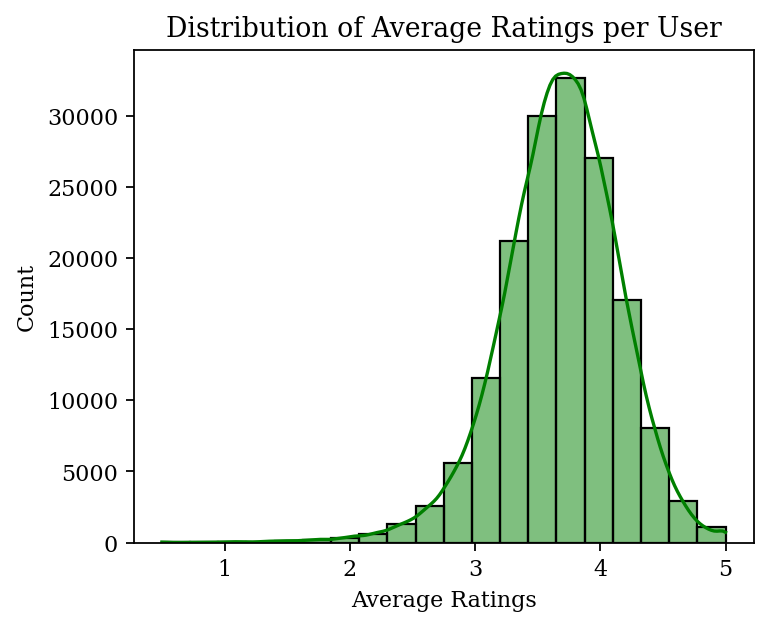

In [6]:
# Calculate average ratings per user
score_dic = defaultdict(list)
score = ratings[['userId', 'rating']].values.tolist()

for user, rating in score:
    score_dic[user].append(rating)

ave_score = [np.mean(s) for _, s in score_dic.items()]
print('Average:', np.mean(ave_score))
print('Std:', np.std(ave_score))

# Set up plot settings
plt.figure(dpi=160, figsize=(5, 4))
config = {
    "font.family": "serif",  
    "font.size": 10,
    "mathtext.fontset": 'stix',
}
rcParams.update(config)

# Use histplot to visualize the distribution of average ratings
sns.histplot(ave_score, bins=20, color='g', kde=True)

plt.xlabel("Average Ratings")
plt.title("Distribution of Average Ratings per User")
plt.show()

# 2. Model Training and Evaluation

## KNNB

In [7]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [8]:
sampled_ratings = ratings.sample(frac=0.001, random_state=42)

In [9]:
sampled_ratings

,userId,movieId,rating,timestamp
15347762,99476,104374,3.5,1467897440
16647840,107979,2634,4.0,994007728
23915192,155372,1614,3.0,1097887531
10052313,65225,7153,4.0,1201382275
12214125,79161,500,5.0,1488915363
...,...,...,...,...
2627605,17474,89208,2.0,1448038357
14149714,91687,2571,2.0,1164597068
1676199,11200,24,2.0,880220964
12542727,81108,1289,4.0,1218566977


In [10]:
reader = Reader(rating_scale=(1, 5))

In [11]:
data = Dataset.load_from_df(sampled_ratings[["userId", "movieId", "rating"]], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [12]:
sim_options = {
    "name": "MSD",
    'user_based': True
}
knnb = KNNBasic(k=40, min_k=1, sim_options=sim_options, verbose=False)
knnb.fit(trainset)

### Generating Recommendations
#### Generate the top 10 recommendations for a specific user (e.g. user ID 99476)

In [13]:
# Specify the user ID for whom to generate recommendations
user_id = 99476
# Convert the user_id into the internal ID used by the KNN model
user_inner_id = knnb.trainset.to_inner_uid(user_id)
# Get all the movies the user has rated (watched)
user_ratings = knnb.trainset.ur[user_inner_id]
k = 10  # Number of top recommendations to generate

In [14]:
# Get the internal IDs of all the movies in the dataset
all_movie_inner_ids = knnb.trainset.all_items()

In [15]:
# Filter out the movies the user has already watched (rated)
user_watched_movie_inner_ids = [movie_id for (movie_id, _) in user_ratings]
# Find the movies the user has not watched
unwatched_movie_inner_ids = set(all_movie_inner_ids) - set(user_watched_movie_inner_ids)

In [16]:
# Predict ratings for all the movies the user hasn't watched
predictions = [knnb.predict(user_id, knnb.trainset.to_raw_iid(inner_id)) for inner_id in unwatched_movie_inner_ids]

In [17]:
# Sort the predictions by the estimated rating in descending order and select the top K movies
top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:k]

In [18]:
# Print the top K recommendations, including movie IDs, titles, and predicted ratings
for pred in top_predictions:
    movie_id = pred.iid
    # Get the movie title from the movies_df dataset
    movie_title = movies[movies['movieId'] == movie_id].iloc[0, 1]  
    # Print the movie ID, title, and the predicted rating
    print(f"MovieID: {movie_id}, MovieTitle: {movie_title}, PredictiveRating: {pred.est}")

MovieID: 26524, MovieTitle: Times of Harvey Milk, The (1984), PredictiveRating: 3.5296533333333335
MovieID: 1259, MovieTitle: Stand by Me (1986), PredictiveRating: 3.5296533333333335
MovieID: 2475, MovieTitle: 52 Pick-Up (1986), PredictiveRating: 3.5296533333333335
MovieID: 318, MovieTitle: Shawshank Redemption, The (1994), PredictiveRating: 3.5296533333333335
MovieID: 68319, MovieTitle: X-Men Origins: Wolverine (2009), PredictiveRating: 3.5296533333333335
MovieID: 8810, MovieTitle: AVP: Alien vs. Predator (2004), PredictiveRating: 3.5296533333333335
MovieID: 1041, MovieTitle: Secrets & Lies (1996), PredictiveRating: 3.5296533333333335
MovieID: 2527, MovieTitle: Westworld (1973), PredictiveRating: 3.5296533333333335
MovieID: 4369, MovieTitle: Fast and the Furious, The (2001), PredictiveRating: 3.5296533333333335
MovieID: 4995, MovieTitle: Beautiful Mind, A (2001), PredictiveRating: 3.5296533333333335


In [23]:
#using KNNBasic model,computing accuracy metrics on the data and rm_data
KNNB_result = cross_validate(knnb, data, measures=['RMSE', 'MAE'], cv=5, verbose=True, n_jobs=-1)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0668  1.0667  1.0706  1.0594  1.0751  1.0677  0.0052  
MAE (testset)     0.8397  0.8416  0.8501  0.8419  0.8513  0.8449  0.0048  
Fit time          3.11    3.06    3.01    3.18    3.13    3.10    0.06    
Test time         0.04    0.04    0.03    0.04    0.03    0.04    0.00    


In [24]:
from surprise import SVD

# Create SVD model
svd = SVD()

# Use SVD model to compute accuracy metrics
SVD_result = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True, n_jobs=-1)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0169  1.0253  1.0102  1.0139  1.0324  1.0198  0.0080  
MAE (testset)     0.7949  0.7876  0.7867  0.7937  0.8022  0.7930  0.0056  
Fit time          0.17    0.18    0.19    0.16    0.18    0.17    0.01    
Test time         0.02    0.02    0.02    0.03    0.02    0.02    0.00    


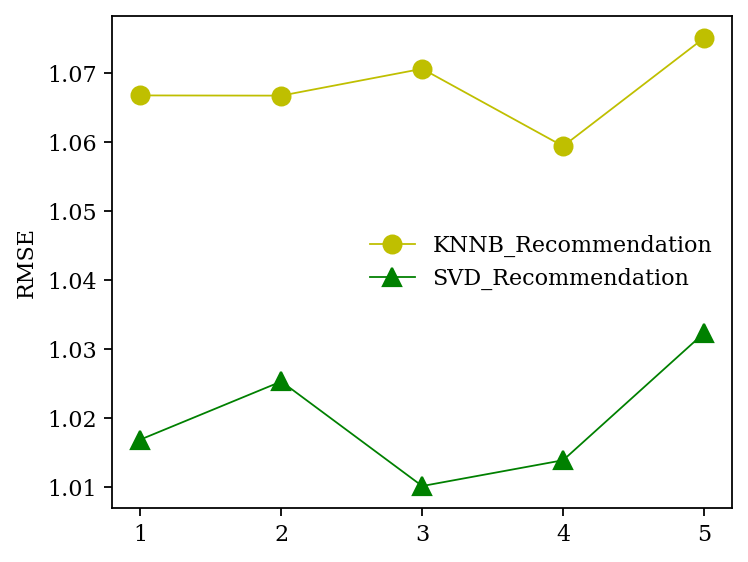

In [25]:
#Visaulize RMSE and MAE
fig = plt.figure(dpi = 160,figsize=(5,4)) 
config = {
"font.family":"serif",    #serif
"font.size": 10,
"mathtext.fontset":'stix',
}
rcParams.update(config)
plt.plot(np.arange(1,6),KNNB_result['test_rmse'], color="y", lw=0.8, ls='-', marker='o', ms=8)
plt.plot(np.arange(1,6),SVD_result['test_rmse'], color='green', lw=0.8,  marker='^', ms=8)
plt.xticks([1,2,3,4,5])

plt.legend(['KNNB_Recommendation','SVD_Recommendation'],loc='best',frameon=False)
plt.ylabel('RMSE')
plt.show()